## 4. Road & traffic sign regulations – infrastructure baseline (Riyadh)

Here we use the **Road and traffic sign regulation** Excel files.

Goal:

- Load all quarterly files (Q1–Q4 2024 and Q1 2025) for **Riyadh Roads**.
- Clean the structure so each row is one measurement (e.g. “Number of lanes” with a value).
- Combine all quarters in one tidy DataFrame.
- Build a simple **quarterly summary** of key infrastructure indicators:
  - Total area of road network
  - Number of lanes
  - Number of intersections
  - Number of main and secondary streets
- Create a few simple ratios such as **lanes per intersection**.
- Plot these indicators over time to explain how complex and dense Riyadh’s road network is.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path  # <-- this is the missing one

In [4]:
# Set folder for traffic sign regulation files and list them

SIGNS_DIR = Path("..") / "Data" / "traffic_sign_regulation"

sign_files = sorted(SIGNS_DIR.glob("Road_and_traffic_sign_regulations_*.xlsx"))
sign_files

[WindowsPath('../Data/traffic_sign_regulation/Road_and_traffic_sign_regulations_Q1_2024_45a34f9178.xlsx'),
 WindowsPath('../Data/traffic_sign_regulation/Road_and_traffic_sign_regulations_Q1_2025_38ebceb838.xlsx'),
 WindowsPath('../Data/traffic_sign_regulation/Road_and_traffic_sign_regulations_Q2_2024_7b9e761952.xlsx'),
 WindowsPath('../Data/traffic_sign_regulation/Road_and_traffic_sign_regulations_Q3_2024_495a95b2c3.xlsx'),
 WindowsPath('../Data/traffic_sign_regulation/Road_and_traffic_sign_regulations_Q4_2024_728e3762ab.xlsx')]

### 4.1 Helper function to clean one regulation file

Each Excel file has:

- A first row that contains the column labels (Month, Quarter, Year, Group, Item, Unit, Number),
- English headers in most files, and Arabic headers in one file,
- One block per month inside the quarter.

This function:

- Treats the first row as the header,
- Standardizes column names to: `month, quarter, year, group, item, unit, value`,
- Maps Arabic labels to English for both **items** and **units**,
- Forward-fills month/quarter/year,
- Keeps only the rows with an actual item and numeric value.

In [5]:
import os

def load_sign_regulation_file(path: Path) -> pd.DataFrame:
    """Load one 'Road_and_traffic_sign_regulations' Excel file and return a tidy DataFrame."""
    raw = pd.read_excel(path)

    # Use the first row as header, then drop it
    df = raw.copy()
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index(drop=True)

    # Clean column names
    df.columns = df.columns.astype(str).str.strip()

    # Map English + Arabic headers to common names
    rename_map = {
        "Month": "month", "الشهر": "month",
        "Quarter": "quarter", "الربع": "quarter",
        "Year": "year", "السنة": "year",
        "Group": "group", "المجموعة": "group",
        "Item": "item", "البند": "item",
        "Unit": "unit", "الوحدة": "unit",
        "Number": "value", "العدد": "value",
    }
    df = df.rename(columns=rename_map)

    # Forward-fill basic info (month, quarter, year, group)
    for col in ["month", "quarter", "year", "group"]:
        if col in df.columns:
            df[col] = df[col].ffill()

    # If item/value are missing we cannot use this file
    if "item" not in df.columns or "value" not in df.columns:
        raise ValueError(f"'item' or 'value' column missing in {path.name}; columns: {df.columns}")

    # Clean item and unit text
    df["item"] = df["item"].astype(str).str.strip()
    df["unit"] = df.get("unit", pd.Series(index=df.index, dtype=object)).astype(str).str.strip()

    # Map Arabic item labels to English equivalents
    item_map = {
        "اجمالى مساحة شبكة الطرق": "Total area of road network",
        "اجمالى عدد الشوارع الرئيسية والفرعية": "Total number of main and secondary streets",
        "اجمالى مساحة الشوارع الرئيسية": "Total area of main streets",
        "اجمالى عدد الشوارع الرئيسية": "Total number of main streets",
        "اجمالى مساحة الشوارع الفرعية": "Total Area of Secondary Streets",
        " اجمالى مساحة الشوارع الفرعية": "Total Area of Secondary Streets",
        "اجمالى عدد الشوارع الفرعية": "Total number of secondary streets",
        " اجمالى عدد الشوارع الفرعية": "Total number of secondary streets",
        "عدد الاحياء": "Number of neighborhoods",
        "عدد المناطق": "Number of regions",
        "عدد المقاطع": "Number of clips",
        "عدد الحارات": "Number of lanes",
        "عدد التقاطعات": "Number of intersections",
        "عدد عينات التقاطعات": "Number of intersection samples",
    }
    df["item"] = df["item"].replace(item_map)

    # Map Arabic units to English units
    unit_map = {
        "متر مربع": "m²",
        "شارع": "street",
        "حي": "neighbourhood",
        "منطقة": "area",
        "مقطع": "section",
        "حارة": "Lane",
        "تقاطع": "section",
        "عينة تقاطع": "Sample junction",
    }
    df["unit"] = df["unit"].replace(unit_map)

    # Keep only rows with a real item and numeric value
    df = df[df["item"].notna()].copy()
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    # Add source file name for reference
    df["source_file"] = path.name

    # Keep the main columns
    keep_cols = ["year", "quarter", "month", "group", "item", "unit", "value", "source_file"]
    return df[keep_cols]


### 4.2 Load and combine all regulation files

Here we:

- Apply the helper function to each Excel file,
- Concatenate all results into one **tidy** DataFrame,
- Do a quick check of the structure.

Each row now represents one measurement (e.g. “Number of lanes” in a given month, quarter, and year).

In [6]:
sign_frames = [load_sign_regulation_file(path) for path in sign_files]
sign_all = pd.concat(sign_frames, ignore_index=True)

sign_all.head()

C:\Users\DSC-GDP48\AppData\Local\Temp\ipykernel_3224\180839474.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].ffill()
C:\Users\DSC-GDP48\AppData\Local\Temp\ipykernel_3224\180839474.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].ffill()
C:\Users\DSC-GDP48\AppData\Local\Temp\ipykernel_3224\180839474.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, 

,year,quarter,month,group,item,unit,value,source_file
0,2024,Q1,January,Riyadh Roads,Total area of road network,m²,262831178.4,Road_and_traffic_sign_regulations_Q1_2024_45a3...
1,2024,Q1,January,Riyadh Roads,Total number of main and secondary streets,street,72430.0,Road_and_traffic_sign_regulations_Q1_2024_45a3...
2,2024,Q1,January,Riyadh Roads,Total area of main streets,m²,81091409.4,Road_and_traffic_sign_regulations_Q1_2024_45a3...
3,2024,Q1,January,Riyadh Roads,Total number of main streets,street,2242.0,Road_and_traffic_sign_regulations_Q1_2024_45a3...
4,2024,Q1,January,Riyadh Roads,Total Area of Secondary Streets,m²,181739769.0,Road_and_traffic_sign_regulations_Q1_2024_45a3...


### 4.3 Build a quarterly infrastructure summary for Riyadh

For our policy work we only need **quarter-level** indicators.

Here we:

- Group by `year`, `quarter`, `item`, and `unit`,
- For each combination take the **maximum** value within the quarter  
  (for infrastructure counts this is a good proxy for the end-of-quarter level),
- Then pivot the table so each row is one quarter and each column is one indicator
  (e.g. Total area of road network, Number of lanes, etc.).

In [7]:
# Aggregate to quarter level (take max value within each quarter)
sign_quarterly_long = (
    sign_all
    .groupby(["year", "quarter", "item", "unit"], as_index=False)
    .agg(value=("value", "max"))
)

# Pivot to wide format: one row per quarter, columns are the different items
sign_quarterly = (
    sign_quarterly_long
    .pivot(index=["year", "quarter"], columns="item", values="value")
    .reset_index()
)

sign_quarterly

item,year,quarter,Number of clips,Number of intersection samples,Number of intersections,Number of lanes,Number of neighborhoods,Number of regions,Total Area of Secondary Streets,Total area of main streets,Total area of road network,Total number of main and secondary streets,Total number of main streets,Total number of secondary streets
0,2024,Q1,9688.0,199681.0,4568.0,33616.0,16.0,2768.0,1.830711e+08,8.111772e+07,2.641889e+08,73016.0,2242.0,70774.0
1,2024,Q2,9691.0,199736.0,4568.0,33626.0,16.0,2770.0,1.835053e+08,8.113279e+07,2.646381e+08,73196.0,2243.0,70953.0
2,2024,Q3,9698.0,200030.0,4679.0,33640.0,16.0,2778.0,1.839101e+08,8.218643e+07,2.660965e+08,73333.0,2244.0,71089.0
3,2025,Q1,9712.0,200145.0,4680.0,33687.0,16.0,2778.0,1.839206e+08,8.221917e+07,2.661272e+08,73336.0,2247.0,71089.0


### 4.4 Create simple infrastructure ratios

To link this more clearly to **congestion and safety**, we create simple ratios:

- **Lanes per intersection**  
  → proxy for how large and complex intersections are.
- **Intersections per million m² of road network**  
  → proxy for intersection density.

These indicators will help justify **where** and **why** smart traffic-light sensors are needed.

In [8]:
# Make a copy to add derived metrics
infra_quarterly = sign_quarterly.copy()

# Avoid division by zero by using .where(...)
infra_quarterly["lanes_per_intersection"] = (
    infra_quarterly["Number of lanes"] /
    infra_quarterly["Number of intersections"].where(infra_quarterly["Number of intersections"] != 0)
)

# Road area is in m² → convert to millions of m² to keep numbers reasonable
infra_quarterly["road_area_million_m2"] = infra_quarterly["Total area of road network"] / 1_000_000

infra_quarterly["intersections_per_million_m2"] = (
    infra_quarterly["Number of intersections"] /
    infra_quarterly["road_area_million_m2"].where(infra_quarterly["road_area_million_m2"] != 0)
)

infra_quarterly

item,year,quarter,Number of clips,Number of intersection samples,Number of intersections,Number of lanes,Number of neighborhoods,Number of regions,Total Area of Secondary Streets,Total area of main streets,Total area of road network,Total number of main and secondary streets,Total number of main streets,Total number of secondary streets,lanes_per_intersection,road_area_million_m2,intersections_per_million_m2
0,2024,Q1,9688.0,199681.0,4568.0,33616.0,16.0,2768.0,1.830711e+08,8.111772e+07,2.641889e+08,73016.0,2242.0,70774.0,7.359019,264.188851,17.290662
1,2024,Q2,9691.0,199736.0,4568.0,33626.0,16.0,2770.0,1.835053e+08,8.113279e+07,2.646381e+08,73196.0,2243.0,70953.0,7.361208,264.638126,17.261307
2,2024,Q3,9698.0,200030.0,4679.0,33640.0,16.0,2778.0,1.839101e+08,8.218643e+07,2.660965e+08,73333.0,2244.0,71089.0,7.189570,266.096510,17.583846
3,2025,Q1,9712.0,200145.0,4680.0,33687.0,16.0,2778.0,1.839206e+08,8.221917e+07,2.661272e+08,73336.0,2247.0,71089.0,7.198077,266.127229,17.585574


### 4.5 Plot key infrastructure indicators over time

Now we make two simple plots:

1. **Number of lanes and intersections by quarter** – shows how large and complex the network is.
2. **Lanes per intersection and intersections per million m²** – shows how dense and complex intersections are.

These plots can be used directly in slides to explain the **infrastructure side** of congestion in Riyadh.

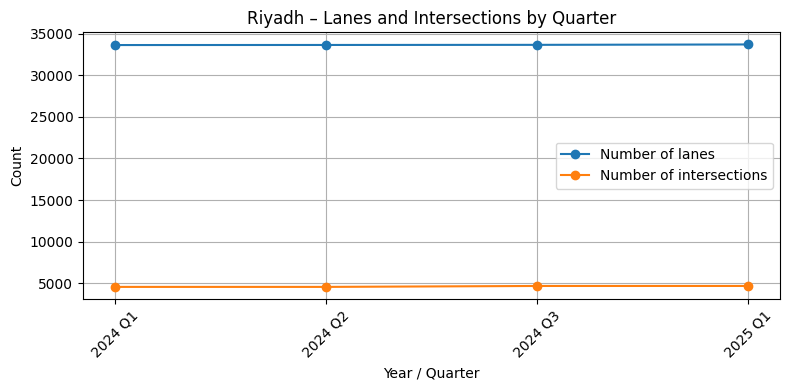

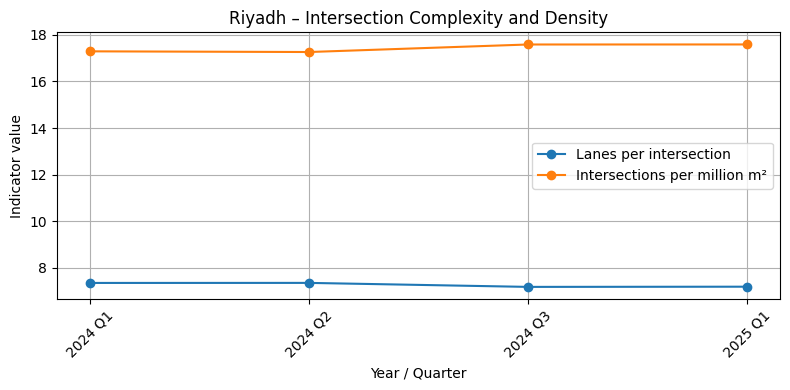

In [9]:
# Plot number of lanes and intersections over time
plt.figure(figsize=(8, 4))
plt.plot(infra_quarterly["year"].astype(str) + " " + infra_quarterly["quarter"],
         infra_quarterly["Number of lanes"], marker="o", label="Number of lanes")
plt.plot(infra_quarterly["year"].astype(str) + " " + infra_quarterly["quarter"],
         infra_quarterly["Number of intersections"], marker="o", label="Number of intersections")
plt.title("Riyadh – Lanes and Intersections by Quarter")
plt.xlabel("Year / Quarter")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot lanes per intersection and intersections per million m²
plt.figure(figsize=(8, 4))
plt.plot(infra_quarterly["year"].astype(str) + " " + infra_quarterly["quarter"],
         infra_quarterly["lanes_per_intersection"], marker="o", label="Lanes per intersection")
plt.plot(infra_quarterly["year"].astype(str) + " " + infra_quarterly["quarter"],
         infra_quarterly["intersections_per_million_m2"], marker="o",
         label="Intersections per million m²")
plt.title("Riyadh – Intersection Complexity and Density")
plt.xlabel("Year / Quarter")
plt.ylabel("Indicator value")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.6 How this links to accidents and our sensor proposal

With this section we now have:

- **Quarterly infrastructure levels** for Riyadh (lanes, intersections, total road area, etc.).
- Simple ratios that describe **how dense and complex** the network is.

Later we can:

- Combine these indicators with **accident data** (e.g. accidents per intersection or per lane),
- Highlight that **Riyadh has many intersections and high intersection density**,  
  so smart traffic-light sensors placed at the **busiest and most complex intersections**  
  should deliver strong safety and congestion benefits.

This prepares the ground for joining with:
- Busiest streets (traffic density),
- Accident hotspots,
- And finally our **sensor deployment plan** for priority corridors.